In [3]:
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8)

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [4]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set()
from IPython.display import SVG, display

In [5]:

df_train = pd.read_csv('../train.csv', index_col = 0)
df_valid = pd.read_csv('../valid.csv', index_col = 0)
df_test = pd.read_csv('../test.csv', index_col = 0)


number of all smiles:  9999
number of successfully processed smiles:  9999


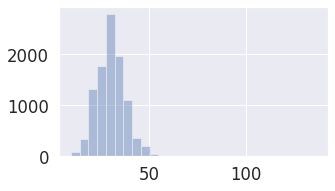

In [6]:
task_name = 'Malaria Bioactivity'
tasks = ['Loge EC50']

raw_filename = "./malaria-processed.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename, names = ["Loge EC50", "smiles"])
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()


In [7]:
random_seed = 68
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 200
epochs = 800

p_dropout= 0.03
fingerprint_dim = 200

weight_decay = 4.3 # also known as l2_regularization_lambda
learning_rate = 4
radius = 2
T = 1
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [8]:
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

feature dicts file saved as ./malaria-processed.pickle


,Loge EC50,smiles,cano_smiles


In [9]:
train_df = remained_df[remained_df.smiles.isin(df_train.smiles)]
valid_df = remained_df[remained_df.smiles.isin(df_valid.smiles)]
test_df = remained_df[remained_df.smiles.isin(df_test.smiles)]
print(len(train_df), len(valid_df), len(test_df))

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

7999 1000 1000


In [10]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
loss_function = nn.MSELoss()
model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

863604
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
mol_GRUCell.weight_ih torch.Size([600, 200])
mol_GRUCell.weight_hh torch.Size([600, 200])
mol_GRUCell.bias_ih torch.Size([600])
mol_GRUCell.bias_hh torch.Size([600])
mol_align.weight torch.Size([1, 400])
mol_align.bias torch.Size([1])
mol_attend.weight torch.Si

In [11]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        
        optimizer.zero_grad()
        loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1,1))     
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    test_MAE_list = []
    test_MSE_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
#         print(batch_df)
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
#         print(x_mask[:2],atoms_prediction.shape, mol_prediction,MSE)
        
        test_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        test_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    return np.array(test_MAE_list).mean(), np.array(test_MSE_list).mean()


In [13]:
best_param ={}
best_param["train_epoch"] = 0
best_param["valid_epoch"] = 0
best_param["train_MSE"] = 9e8
best_param["valid_MSE"] = 9e8

for epoch in range(800):
    train_MAE, train_MSE = eval(model, train_df)
    valid_MAE, valid_MSE = eval(model, valid_df)

    if train_MSE < best_param["train_MSE"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE"] = train_MSE
    if valid_MSE < best_param["valid_MSE"]:
        best_param["valid_epoch"] = epoch
        best_param["valid_MSE"] = valid_MSE
        if valid_MSE < 1.1:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
    if (epoch - best_param["train_epoch"] >2) and (epoch - best_param["valid_epoch"] >18):        
        break
    print(epoch, train_MSE, valid_MSE)
    
    train(model, train_df, optimizer, loss_function)


0 1.8231206 1.5850111
1 1.4737025 1.3224666
2 1.4819328 1.3554331
3 1.448957 1.3054091
4 1.4506499 1.328714
5 1.4358945 1.287479
6 1.3988016 1.266164
7 1.3748107 1.2526745
8 1.3596209 1.2484986
9 1.364829 1.2448978
10 1.3135163 1.2055879
11 1.2953302 1.1994951
12 1.2873223 1.1868283
13 1.301818 1.1957961
14 1.2624898 1.1756396
15 1.254797 1.172166
16 1.25707 1.1607052
17 1.2506939 1.1714171
18 1.2645215 1.1609614
19 1.2357311 1.1573133
20 1.2483815 1.151521
21 1.2505984 1.1951919
22 1.223714 1.1572326
23 1.2387567 1.1545748
24 1.2321849 1.1847199
25 1.2183815 1.1399038
26 1.2172674 1.1423466
27 1.2074571 1.1458318
28 1.2573313 1.1609409
29 1.2032102 1.145439
30 1.2123 1.1585603
31 1.2246357 1.1553897
32 1.195834 1.1433704
33 1.1943012 1.1382679
34 1.1919385 1.1286156
35 1.2192286 1.1936487
36 1.2004039 1.1601228
37 1.1937954 1.1244218
38 1.1810304 1.1265198
39 1.2020233 1.1328975
40 1.180257 1.1377803
41 1.1884416 1.1266875
42 1.184468 1.1315094
43 1.2320951 1.2217681
44 1.1905584 1.15

/home/shenwanxiang/anaconda3/envs/deepchem/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Fingerprint. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/shenwanxiang/anaconda3/envs/deepchem/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/shenwanxiang/anaconda3/envs/deepchem/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/shenwanxiang/anaconda3/envs/deepchem/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GRUCe

61 1.1384203 1.0982109
62 1.1367127 1.1004477
63 1.1346424 1.0960274
64 1.1511232 1.1235794
65 1.1380819 1.1067777
66 1.1435003 1.1092867
67 1.1310574 1.0790007
68 1.1305568 1.0965011
69 1.13491 1.1132658
70 1.1391661 1.1166869
71 1.127321 1.0902389
72 1.1178113 1.0847071
73 1.1593434 1.1476911
74 1.127375 1.0780425
75 1.1244214 1.1017891
76 1.1225153 1.0945094
77 1.1327673 1.124561
78 1.1125419 1.0871116
79 1.1206583 1.0528625
80 1.1053041 1.0630258
81 1.1087976 1.0630783
82 1.1181461 1.0937276
83 1.1137935 1.0565305
84 1.1077107 1.0678939
85 1.1109064 1.077891
86 1.0895753 1.055299
87 1.0990738 1.0457697
88 1.0959197 1.0467846
89 1.089393 1.0615774
90 1.0924337 1.0531338
91 1.0869739 1.0569397
92 1.0784527 1.043658
93 1.0954661 1.0414544
94 1.0953207 1.0906618
95 1.0741374 1.0417103
96 1.0727465 1.0387665
97 1.0691195 1.0394622
98 1.0670162 1.0385833
99 1.0834857 1.0301609
100 1.1273556 1.1322238
101 1.063482 1.030903
102 1.0621797 1.0386001
103 1.1132954 1.0511214
104 1.05774 1.0288

In [15]:
best_param

{'train_epoch': 195,
 'valid_epoch': 174,
 'train_MSE': 0.9121855,
 'valid_MSE': 0.95341516}

In [20]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')     

# best_model_dict = best_model.state_dict()
# best_model_wts = copy.deepcopy(best_model_dict)

# model.load_state_dict(best_model_wts)
# (best_model.align[0].weight == model.align[0].weight).all()
_, train_MSE = eval(best_model, train_df)
_, valid_MSE = eval(best_model, valid_df)
_, test_MSE = eval(best_model, test_df)
print("best epoch:",best_param["valid_epoch"],"\n","valid MSE:",valid_MSE)

best epoch: 174 
 valid MSE: 0.95341516


In [18]:
import numpy as np


In [22]:
np.sqrt(train_MSE)

0.9762084

In [25]:
np.sqrt(valid_MSE)

0.9764298

In [26]:
np.sqrt(test_MSE)

1.0670485

In [27]:
train_MSE

0.9529828